In [1]:
# https://www.digitalocean.com/community/tutorials/training-validation-and-accuracy-in-pytorch

## Setup

In [ ]:
import numpy as np
from datasets import load_dataset
import sys
import torch

from PIL import Image
import torch.nn as nn
from src.datasets.imagenet1k import make_imagenet1k as asdf
from src import helper
from src.models import vision_transformer
from datasets import Dataset, DatasetDict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from src.transforms import make_transforms
from torchvision import datasets, transforms
from torch.utils.data import random_split

%load_ext autoreload
%autoreload 2

/home/tomtom/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load in target encoder

In [3]:
CHECKPOINT_FILE = './checkpoint/IN1K-vit.h.14-300e.pth.tar'
checkpoint = torch.load(CHECKPOINT_FILE, map_location=torch.device('cpu'))
target_encoder_weights = checkpoint['target_encoder']
del checkpoint
import gc
gc.collect()


/tmp/ipykernel_17447/1272978648.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_FILE, map_location=torch.device('cpu'))


9

## Copying what Assran et. al did in their code, and just setting up the model to not require gradient calculations

In [4]:
import copy
d = torch.device('cuda:0')
torch.cuda.set_device(d)

encoder, predictor = helper.init_model(
    device = d,
    patch_size=14,
    crop_size=224,
    pred_depth=12,
    pred_emb_dim=384,
    model_name='vit_huge')

target_encoder = copy.deepcopy(encoder)

target_encoder_weights = {k.replace('module.', ''): v for k, v in target_encoder_weights.items()}

target_encoder.eval()

# Just want to train the linear classifier part.
for p in target_encoder.parameters():
    p.requires_grad = False

msg = target_encoder.load_state_dict(target_encoder_weights)

INFO:root:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  )
  (blocks): ModuleList(
    (0-31): 32 x Block(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
)


## Encode Classify Net is the target encoder from IJEPA with one hidden fully connected layer and the output layer. Very simple!

In [5]:
from my_code.NN import EncodeClassifyNet

NN = EncodeClassifyNet(target_encoder)
NN = NN.to(d)

## Make train, val, and test

In [6]:
cifar10 = load_dataset("cifar10")

full_train_set = cifar10['train']

train_size = int(0.9 * len(full_train_set))
val_size   = len(full_train_set) - train_size

train_set, val_set = random_split(full_train_set, [train_size, val_size])

val_set, _ = random_split(val_set, [train_size, len(val_set) - train_size])

test_set = cifar10['test']


TRAIN_BATCH_SIZE = 45
EVAL_BATCH_SIZE  = 50

print(f"Length of train: {len(train_set)}, Length of val: {len(val_set)}, Length of Test: {len(test_set)}")

Length of train: 45000, Length of val: 5000, Length of Test: 10000


### More copying of Assran et al. Just resizing and cropping, no other data augmentations

In [7]:
from my_code.data_loader import Transformed_Cifar

transform = make_transforms(
crop_size=224,
crop_scale=[0.3, 1.0],
gaussian_blur=False,
horizontal_flip=False,
color_distortion=False,
color_jitter=0.0)

transform_with_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transform
])

INFO:root:making imagenet data transforms


In [8]:
transformed_train = Transformed_Cifar(train_set, transform_with_resize)
transformed_test  = Transformed_Cifar(test_set, transform_with_resize)
transformed_val   = Transformed_Cifar(val_set, transform_with_resize)

## Using some ideas from assignment 5 'GANs-PyTorch.ipynb' and pytorch tutorial from TAs

In [9]:
def accuracy(model, loader, dataset_len):
    model.eval()
    num_correct = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to('cuda'), labels.to('cuda')
            predictions = torch.argmax(model(imgs), dim=1)
            num_correct += torch.sum(predictions == labels)

    return (num_correct / dataset_len).item()

In [10]:
def training_loop(model, train_loader, val_loader, optimizer, loss_function, num_epochs=1):
    model.train()
    losses = []
    iter = 0
    for epoch in range(0, num_epochs):
        for imgs, labels in train_loader:
            
            imgs, labels = imgs.to('cuda'), labels.to('cuda')

            forward = model(imgs)

            loss = loss_function(forward, labels)
            losses.append(loss.item())
            
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            iter += 1
            if iter % 100 == 0:
                print(f"Step {iter}, \tTraining Loss: {loss.item()}, \tValidation Accuracy: {accuracy(model, val_loader, int(0.1 * len(full_train_set)))}" )
            
    return losses


# Training the model for 1 epoch only

In [11]:
loss_fn = nn.CrossEntropyLoss()

training_loader = DataLoader(transformed_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

from my_code.NN import EncodeLNClassify

NN = EncodeLNClassify(target_encoder)
NN = NN.to(d)
optimizer = optim.Adam(NN.parameters(), lr=0.00005)


val = DataLoader(transformed_val, batch_size=EVAL_BATCH_SIZE, shuffle=False)
test = DataLoader(transformed_test, batch_size=EVAL_BATCH_SIZE, shuffle=False)

losses = training_loop(NN, training_loader, val, optimizer=optimizer, loss_function=loss_fn, num_epochs=1)

Step 100, 	Training Loss: 0.711243212223053, 	Validation Accuracy: 0.7978000044822693
Step 200, 	Training Loss: 0.5793476104736328, 	Validation Accuracy: 0.8181999921798706
Step 300, 	Training Loss: 0.49884364008903503, 	Validation Accuracy: 0.8294000029563904
Step 400, 	Training Loss: 0.5242096185684204, 	Validation Accuracy: 0.8389999866485596
Step 500, 	Training Loss: 0.3881070911884308, 	Validation Accuracy: 0.8459999561309814
Step 600, 	Training Loss: 0.4977837800979614, 	Validation Accuracy: 0.8499999642372131
Step 700, 	Training Loss: 0.5465694665908813, 	Validation Accuracy: 0.8511999845504761
Step 800, 	Training Loss: 0.44094976782798767, 	Validation Accuracy: 0.8673999905586243
Step 900, 	Training Loss: 0.4223916232585907, 	Validation Accuracy: 0.8503999710083008
Step 1000, 	Training Loss: 0.44921737909317017, 	Validation Accuracy: 0.8603999614715576


In [ ]:
import numpy as np
np.save('./loss.npy', losses)

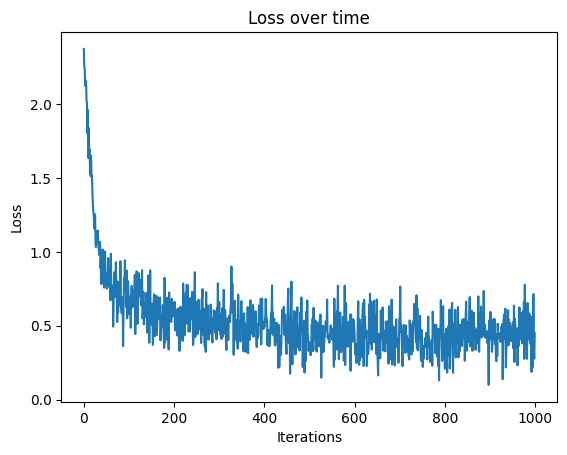

In [8]:
import matplotlib.pyplot as plt
import numpy as np
losses = np.load('./loss.npy')
plt.figure()
plt.title("Loss over time")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.plot(losses)
plt.savefig('./loss_curve.png')

In [13]:
print("Test accuracy after one epoch: ", accuracy(NN, test, len(transformed_test)))

Test accuracy after one epoch:  0.8574000000953674


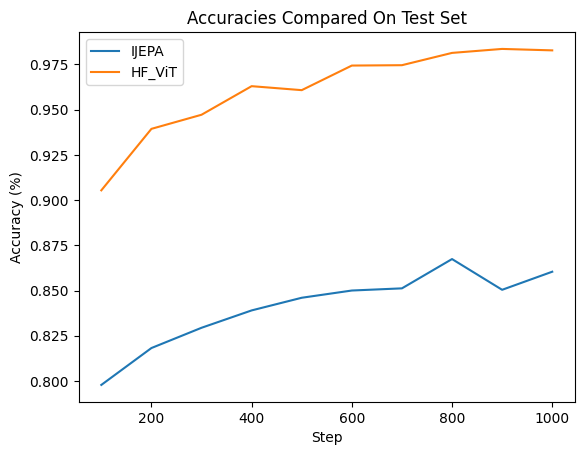

In [10]:
steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

IJEPA_acc = [0.7978, 0.8182, 0.8294, 0.8390, 0.8460, 0.8500, 0.8512, 0.8674, 0.8504, 0.8604]

vit_acc = [0.9054, 0.9394, 0.9472, 0.9630, 0.9608, 0.9744, 0.9746, 0.9814, 0.9836, 0.9828]

plt.figure()
plt.title("Accuracies Compared On Test Set")
plt.ylabel("Accuracy (%)")
plt.xlabel("Step")
plt.plot(steps, IJEPA_acc, label="IJEPA")
plt.plot(steps, vit_acc, label="HF_ViT")
plt.legend()
plt.savefig('./accuracies.png')